In [1]:
import torch

## 1. Encode 

In [21]:
unique_chars=set()

f = open('pa4Data/train.txt', "r")
line = f.readline()
while line:
    for char in line:
        unique_chars.add(char)
    line = f.readline()

f.close()
    
len(unique_chars)
print(unique_chars)
dictionary = {}
i=0
for char in unique_chars:
    dictionary[char]=i
    i+=1
print(dictionary)

{'m', '/', '{', '!', 'X', '4', 'x', 'N', '>', 'F', 'q', 'U', 'j', 'W', '-', 'b', '(', 'K', 'A', 'T', 'O', 'M', '.', ')', 'c', 'a', ']', '@', '9', 'C', 'v', '2', '#', '*', 'B', 'n', 'R', '|', '\t', 'H', '}', '1', 'p', 'D', '<', 'I', 's', 'J', 'G', '8', '3', 'i', '~', '\\', 'o', 'E', '"', 'y', '[', 't', '6', '?', 'P', ':', '_', 'S', ' ', ',', 'l', 'd', '0', 'k', 'Q', "'", 'Y', 'g', '&', 'L', '5', 'u', '\n', 'h', '=', 'z', 'Z', '^', '+', 'f', 'V', 'r', 'w', '7', 'e'}
{'m': 0, '/': 1, '{': 2, '!': 3, 'X': 4, '4': 5, 'x': 6, 'N': 7, '>': 8, 'F': 9, 'q': 10, 'U': 11, 'j': 12, 'W': 13, '-': 14, 'b': 15, '(': 16, 'K': 17, 'A': 18, 'T': 19, 'O': 20, 'M': 21, '.': 22, ')': 23, 'c': 24, 'a': 25, ']': 26, '@': 27, '9': 28, 'C': 29, 'v': 30, '2': 31, '#': 32, '*': 33, 'B': 34, 'n': 35, 'R': 36, '|': 37, '\t': 38, 'H': 39, '}': 40, '1': 41, 'p': 42, 'D': 43, '<': 44, 'I': 45, 's': 46, 'J': 47, 'G': 48, '8': 49, '3': 50, 'i': 51, '~': 52, '\\': 53, 'o': 54, 'E': 55, '"': 56, 'y': 57, '[': 58, 't': 59

In [44]:
# hot encode data

num_chars = 256

def encodeChar(char):
    output = torch.zeros(num_chars)
    output[ord(char)] = 1
    return output

def encodeSeq(string):
    output=[]
    for char in string:
        output.append(encodeChar(char))
    return torch.stack(output,dim=0)

def encodeFile(filepath):
    output = []
    
    f = open(filepath, "r")
    line = f.readline()
    while line:
        for char in line:
            output.append(encodeChar(char))
        line = f.readline()
    return torch.stack(output,dim=0)
    return output
    f.close()
    
## test function
output = encodeFile('pa4Data/samplemusic.txt')
print(output.size())


torch.Size([1181, 256])


## 2. Generate train chunks

In [45]:
# generate training data

def generate_input_and_labels(filepath):
    encoded_sequence = encodeFile(filepath)
    inputs = encoded_sequence[:-1]
    labels = encoded_sequence[1:]
    
    return inputs,labels

## test function
x_train,y_train = generate_input_and_labels('pa4Data/samplemusic.txt')

print(x_train.size())
print(y_train.size())
print(y_train.size()[1])
print(x_train[:100].size())

x_train[1:] == y_train[:-1]

torch.Size([1180, 256])
torch.Size([1180, 256])
256
torch.Size([100, 256])


tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.uint8)

In [46]:
def generate_chunks_input_and_labels(filepath, chunk_size=100):
    inputs,labels = generate_input_and_labels(filepath)
    input_chunks=[]
    label_chunks=[]
    
    i=0
    while i < inputs.size()[0]:
        input_chunks.append(inputs[i:(i+chunk_size)])
        label_chunks.append(labels[i:(i+chunk_size)])
        i+=chunk_size
    
    return input_chunks,label_chunks

x_chunks, y_chunks = generate_chunks_input_and_labels('pa4Data/samplemusic.txt')

print(len(x_chunks))
print(len(y_chunks))

12
12


In [1]:
import Dataloader

dataloader = Dataloader.Dataloader()

x_chunks, y_chunks = dataloader.load_data('pa4Data/samplemusic.txt')
print(len(x_chunks))
print(len(y_chunks))

print('\nbreak into chunk:')
print('\teach chunk has 100 chars')
print('\t',x_chunks[0].size())
print('\t',y_chunks[0].size())
print('\teach char is 93 hot encoded seq')
print('\t',(y_chunks[0][0].size()))

12
12

break into chunk:
	each chunk has 100 chars
	 torch.Size([100, 93])
	 torch.Size([100])
	each char is 93 hot encoded seq
	 torch.Size([])


## 3. LSTM Model 

In [4]:
import torch

## RNN MODEL

# 100 neurons in your hidden layer.
# You should use a softmax output and the cross entropy loss.
# Use validation set for tuning hyper-parameters (number of hidden units, optimizer learning rate, chunk-length)

# Evaluate your model on the training and validation set every x iterations over the training batches.

input_siz=93
hidden_siz=100

lstm = torch.nn.LSTM(input_size=input_siz,hidden_size=hidden_siz,num_layers=1,batch_first=True)

# seq_len, batch_size, input_size
'''
i=0
x = x_chunks[i].view(1,x_chunks[i].size()[0],x_chunks[i].size()[1])
print(x.size())
output, (h_n, c_n) = lstm(input=x)
output.size()
'''

class LSTM_play(torch.nn.Module):
    def __init__(self,input_dim=93, hidden_dim=100, output_dim=93, num_layers=1,batch_size=1):
        super(LSTM, self).__init__()
        
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.output_dim=output_dim
        self.num_layers=num_layers
        self.batch_size=1
        
        self.hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        
        # Define the LSTM layer
        self.lstm = torch.nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = torch.nn.Linear(self.hidden_dim, self.output_dim)
    
    def clear_hidden(self):
        #  shape for h + c states: (num_layers * num_directions, batch, hidden_size)
        #  self.hidden = (h,c)
        self.hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of input:  (seq_len, batch, input_size)
        
        seq_len = input.size()[0]
        
        lstm_out, self.hidden = self.lstm(input.view(seq_len, self.batch_size, -1),self.hidden)
        
        print(lstm_out.size())
        
        # output of linear layer
        y_pred = self.linear(lstm_out.view(seq_len, self.hidden_dim))
        #y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred
    

i=0
print('input',x_chunks[i].size())
print('seq_len',x_chunks[i].size()[0])

model = LSTM_play()
print('pred',model(x_chunks[i]).size())




input torch.Size([100, 93])
seq_len 100
torch.Size([100, 1, 100])
pred torch.Size([100, 93])


## 4. Training

In [2]:
## INITIALIZE
import torch
from LSTM import LSTM
import Dataloader

model = LSTM()

#loss_fn = torch.nn.MSELoss(size_average=False)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

num_epochs = 5  


N = 50
N_minibatch_loss = 0.0

In [3]:
## TRAIN
dataloader = Dataloader.Dataloader()

inputs,targets = dataloader.load_data('pa4Data/train.txt')
print('input,target')
print(inputs[0].size())
print(targets[0].size())

val_inputs,val_targets = dataloader.load_data('pa4Data/val.txt')

# Track the loss across training
total_loss = []
avg_minibatch_loss = []
val_losses = []
epochs = []
mini_batches = []

for epoch in range(num_epochs): 
    model.clear_hidden() # zero out hidden/memory state
    
    for i in range(len(inputs)):
        model.train()
        
        # Zero out gradient
        optimizer.zero_grad()
        
        outputs = model(inputs[i])
        
        loss = criterion(outputs, targets[i].long())
          
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Add this iteration's loss to the total_loss
        total_loss.append(loss.item())
        N_minibatch_loss += loss.item()
        
        if i % N == 0: 
            # Print the loss averaged over the last N mini-batches    
            N_minibatch_loss /= N
            print('Epoch %d, average minibatch %d loss: %.3f' %
                (epoch + 1, i, N_minibatch_loss))
            
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            N_minibatch_loss = 0.0
            
            #validation
            print('...validating...')
            val_loss=0.0
            with torch.no_grad():
                for v in range(len(val_inputs)):
                    val_outputs = model(val_inputs[v])
                    val_loss += criterion(val_outputs, val_targets[v])
            val_loss/=len(val_inputs)
            val_losses.append(val_loss.item())
            
            epochs.append(epoch+1)
            minibatches.append(i)
        
            print('Epoch %d, average validation loss: %.3f' %
                (epoch + 1, val_loss))
            
    print("Finished", epoch + 1, "epochs of training")

input,target
torch.Size([100, 93])
torch.Size([100])
Epoch 1, average minibatch 0 loss: 0.091
...validating...
Epoch 1, average validation loss: 4.539
Epoch 1, average minibatch 50 loss: 4.006
...validating...
Epoch 1, average validation loss: 3.837
Epoch 1, average minibatch 100 loss: 3.128
...validating...
Epoch 1, average validation loss: 4.111
Epoch 1, average minibatch 150 loss: 3.637
...validating...
Epoch 1, average validation loss: 3.801
Epoch 1, average minibatch 200 loss: 3.533
...validating...
Epoch 1, average validation loss: 3.830
Epoch 1, average minibatch 250 loss: 3.329
...validating...
Epoch 1, average validation loss: 3.781
Epoch 1, average minibatch 300 loss: 3.376
...validating...
Epoch 1, average validation loss: 3.803
Epoch 1, average minibatch 350 loss: 3.589
...validating...
Epoch 1, average validation loss: 3.807
Epoch 1, average minibatch 400 loss: 3.309
...validating...
Epoch 1, average validation loss: 3.777
Epoch 1, average minibatch 450 loss: 3.415
...vali

Epoch 2, average validation loss: 2.525
Epoch 2, average minibatch 250 loss: 1.860
...validating...
Epoch 2, average validation loss: 2.481
Epoch 2, average minibatch 300 loss: 2.156
...validating...
Epoch 2, average validation loss: 2.520
Epoch 2, average minibatch 350 loss: 2.017
...validating...
Epoch 2, average validation loss: 2.592
Epoch 2, average minibatch 400 loss: 1.980
...validating...
Epoch 2, average validation loss: 2.443
Epoch 2, average minibatch 450 loss: 1.668
...validating...
Epoch 2, average validation loss: 2.541
Epoch 2, average minibatch 500 loss: 1.397
...validating...
Epoch 2, average validation loss: 2.571
Epoch 2, average minibatch 550 loss: 1.827
...validating...
Epoch 2, average validation loss: 2.472
Epoch 2, average minibatch 600 loss: 2.213
...validating...
Epoch 2, average validation loss: 2.482
Epoch 2, average minibatch 650 loss: 1.848
...validating...
Epoch 2, average validation loss: 2.603
Epoch 2, average minibatch 700 loss: 1.646
...validating...


Epoch 3, average minibatch 500 loss: 1.136
...validating...
Epoch 3, average validation loss: 2.331
Epoch 3, average minibatch 550 loss: 1.581
...validating...
Epoch 3, average validation loss: 2.348
Epoch 3, average minibatch 600 loss: 1.964
...validating...
Epoch 3, average validation loss: 2.347
Epoch 3, average minibatch 650 loss: 1.579
...validating...
Epoch 3, average validation loss: 2.421
Epoch 3, average minibatch 700 loss: 1.437
...validating...
Epoch 3, average validation loss: 2.382
Epoch 3, average minibatch 750 loss: 1.323
...validating...
Epoch 3, average validation loss: 2.412
Epoch 3, average minibatch 800 loss: 1.524
...validating...
Epoch 3, average validation loss: 2.497
Epoch 3, average minibatch 850 loss: 1.244
...validating...
Epoch 3, average validation loss: 2.444
Epoch 3, average minibatch 900 loss: 1.521
...validating...
Epoch 3, average validation loss: 2.483
Epoch 3, average minibatch 950 loss: 1.361
...validating...
Epoch 3, average validation loss: 2.396


Epoch 4, average validation loss: 2.349
Epoch 4, average minibatch 800 loss: 1.430
...validating...
Epoch 4, average validation loss: 2.403
Epoch 4, average minibatch 850 loss: 1.129
...validating...
Epoch 4, average validation loss: 2.305
Epoch 4, average minibatch 900 loss: 1.402
...validating...
Epoch 4, average validation loss: 2.336
Epoch 4, average minibatch 950 loss: 1.291
...validating...
Epoch 4, average validation loss: 2.276
Epoch 4, average minibatch 1000 loss: 1.503
...validating...
Epoch 4, average validation loss: 2.233
Epoch 4, average minibatch 1050 loss: 1.389
...validating...
Epoch 4, average validation loss: 2.246
Epoch 4, average minibatch 1100 loss: 1.549
...validating...
Epoch 4, average validation loss: 2.190
Epoch 4, average minibatch 1150 loss: 1.737
...validating...
Epoch 4, average validation loss: 2.273
Epoch 4, average minibatch 1200 loss: 1.526
...validating...
Epoch 4, average validation loss: 2.327
Epoch 4, average minibatch 1250 loss: 1.326
...validati

Epoch 5, average minibatch 1050 loss: 1.346
...validating...
Epoch 5, average validation loss: 2.169
Epoch 5, average minibatch 1100 loss: 1.475
...validating...
Epoch 5, average validation loss: 2.106
Epoch 5, average minibatch 1150 loss: 1.628
...validating...
Epoch 5, average validation loss: 2.166
Epoch 5, average minibatch 1200 loss: 1.460
...validating...
Epoch 5, average validation loss: 2.213
Epoch 5, average minibatch 1250 loss: 1.268
...validating...
Epoch 5, average validation loss: 2.202
Epoch 5, average minibatch 1300 loss: 1.367
...validating...
Epoch 5, average validation loss: 2.159
Epoch 5, average minibatch 1350 loss: 1.569
...validating...
Epoch 5, average validation loss: 2.173
Epoch 5, average minibatch 1400 loss: 1.464
...validating...
Epoch 5, average validation loss: 2.174
Epoch 5, average minibatch 1450 loss: 1.373
...validating...
Epoch 5, average validation loss: 2.187
Epoch 5, average minibatch 1500 loss: 1.350
...validating...
Epoch 5, average validation lo

## 4. Evaluate

In [9]:
import pandas as pd

train_loss_df = pd.DataFrame({'loss':avg_minibatch_loss})
val_loss_df = pd.DataFrame({'loss':val_losses})

model_name="lstm"

val_loss_file = "./output/{}/validation_loss.csv".format(model_name)
train_loss_file = "./output/{}/train_loss.csv".format(model_name)
scores_file = "./output/{}/scores.csv".format(model_name)

train_loss_df.to_csv(train_loss_file)
val_loss_df.to_csv(val_loss_file)

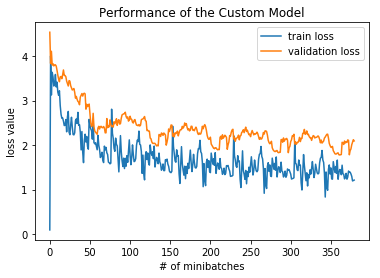

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_losses_from_files(model_name,train_loss_file,val_loss_file,start):
    T = pd.read_csv(train_loss_file)
    V = pd.read_csv(val_loss_file)
    
    #print(list(T['loss']))
    #print(V['loss'])
    
    y = range(len(T))
    train_loss = list(T['loss'])
    val_loss = list(V['loss'])
    #val_loss = val_loss[1:]
    
    if len(val_loss) < len(train_loss) and val_loss:
        val_loss.append(val_loss[-1])
    
    if train_loss:
        plt.plot(y[start:],train_loss[start:])
    if val_loss:
        plt.plot(y[start:],val_loss[start:])
        
    plt.legend(["train loss", "validation loss"])
    plt.xlabel("# of minibatches")
    plt.ylabel("loss value")
    plt.title(model_name + " performance")
    plt.show()
    #plt.savefig("./{}/{}.png".format(model_name,"losses_plot"), dpi=80)

def plot_lossed_from_df(model_name,V,T,start):
    y = T['minibatch']
    train_loss = list(T['loss'])
    val_loss = list(V['loss'])
    #val_loss = val_loss[1:]
    
    if len(val_loss) < len(train_loss) and val_loss:
        val_loss.append(val_loss[-1])
    
    if train_loss:
        plt.plot(y[start:],train_loss[start:])
    if val_loss:
        plt.plot(y[start:],val_loss[start:])
    plt.legend(["train loss", "validation loss"])
    plt.xlabel("# of minibatches")
    plt.ylabel("loss value")
    plt.title("Performance of the Custom Model")
    plt.show()
    
    
model_name="lstm100"
val_loss_file = "./output/{}/validation_loss.csv".format(model_name)
train_loss_file = "./output/{}/train_loss.csv".format(model_name)
scores_file = "./output/{}/scores.csv".format(model_name)

#plot_losses_from_files(model_name,train_loss_file,val_loss_file,0)
train_loss=avg_minibatch_loss
val_loss=val_losses
start=0
y=range(len(train_loss))
plt.plot(y[start:],train_loss[start:])
plt.plot(y[start:],val_loss[start:])
plt.legend(["train loss", "validation loss"])
plt.xlabel("# of minibatches")
plt.ylabel("loss value")
plt.title("Performance of the Custom Model")
plt.show()

In [49]:
def myFun(arg1, arg2, arg3): 
    print("arg1:", arg1) 
    print("arg2:", arg2) 
    print("arg3:", arg3) 
      
# Now we can use *args or **kwargs to 
# pass arguments to this function :  
args = ("Geeks", "for", "Geeks") 
myFun(*args) 
  
kwargs = {"arg1" : "Geeks", "arg2" : "for", "arg3" : "Geeks"} 
myFun(**kwargs) 

myFun(arg2="i'm",arg3="renu",arg1="hi") 


arg1: Geeks
arg2: for
arg3: Geeks
arg1: Geeks
arg2: for
arg3: Geeks
arg1: hi
arg2: i'm
arg3: renu


5
